In [7]:
# necessary headers
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.datasets import make_classification
from sklearn.preprocessing import normalize

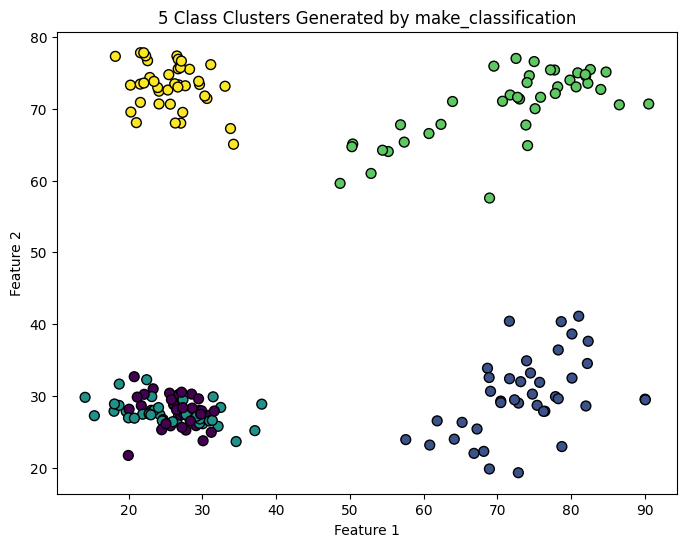

In [8]:
# Generate the dataset
X, y = make_classification(n_samples=200,    # Total number of samples
                           n_features=5,     # Total number of features
                           n_informative=3,  # Number of informative features
                           n_redundant=0,    # One redundant feature
                           n_repeated=2,     # One repeated feature
                           n_clusters_per_class=1,  # One cluster per class
                           n_classes=5,      # Number of classes
                           random_state=42,
                           class_sep=3)

X = normalize(X,axis=1)*50 + 50
# Plot the dataset
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 2], c=y, cmap='viridis', s=50, edgecolor='k')
plt.title('5 Class Clusters Generated by make_classification')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


[[-1, 1, 0], [1, -1, 0], [-1, 0], [-1, 1], []]
[[49.59317912 51.07468831]
 [50.73625959 50.03384748]]


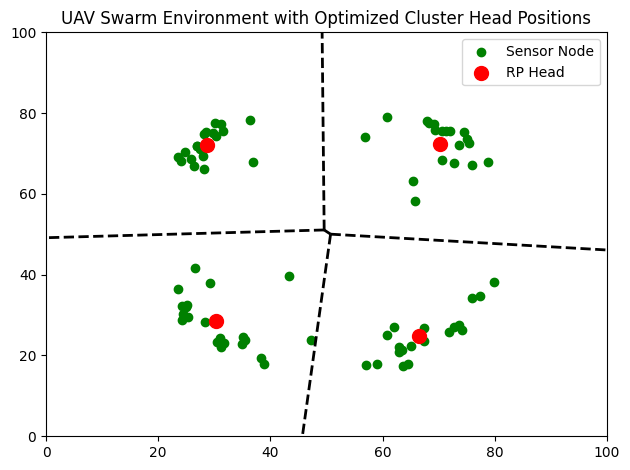

In [13]:
# Constants
GRID_SIZE = 100  # Increasing the grid size for more visible separation
FLYING_HEIGHT = 10  # UAVs fly at a constant height
NUM_UAVS = 2
NUM_AREAS = 5  # NUM_AREAS-1 regions with random number of sensor nodes
NUM_SENSOR_NODES = 100

class Node:
    def __init__(self, node_id, position, area_id, data_rate, buffer_space, memory):
        self.node_id = node_id
        self.position = position  # (x, y) coordinates on the grid
        self.area_id = area_id  # Which cluster area the node belongs to
        self.data_rate = data_rate  # Data generation rate (e.g., packets/sec)
        self.buffer_space = buffer_space  # Buffer capacity for storing data
        self.memory = memory  # Memory of the node
        self.nearest_head = None  # Nearest cluster head (set later)

    def assign_cluster_head(self, cluster_head):
        self.nearest_head = cluster_head

class ClusterHead:
    def __init__(self, head_id, position, area_id, buffer_space, memory):
        self.head_id = head_id
        self.position = position  # (x, y) coordinates on the grid
        self.area_id = area_id  # The cluster/area the head manages
        self.buffer_space = buffer_space  # Buffer capacity for storing data
        self.memory = memory  # Memory of the cluster head
        self.nodes = []  # List of sensor nodes in this cluster

    def add_node(self, node):
        self.nodes.append(node)

    def calculate_centroid(self):
        """Calculate the centroid of the nodes in this cluster to optimize cluster head position."""
        if self.nodes:
            avg_x = np.mean([node.position[0] for node in self.nodes])
            avg_y = np.mean([node.position[1] for node in self.nodes])
            self.position = (avg_x, avg_y)

class UAV:
    def __init__(self, uav_id, position, buffer_space, height=FLYING_HEIGHT):
        self.uav_id = uav_id
        self.position = position  # (x, y) coordinates on the grid
        self.buffer_space = buffer_space  # Buffer capacity for relaying data
        self.height = height  # Flying height, constant in this scenario

class Environment:
    def __init__(self, num_areas, grid_size,num_sensor_nodes):
        self.num_areas = num_areas
        self.grid_size = grid_size
        self.num_sensor_nodes = num_sensor_nodes
        self.nodes = []
        self.cluster_heads = []
        self.uavs = []
        self.setup_environment()

    def setup_environment(self):
        # Generate Random sensor nodes clusters 
        X, y = make_classification(n_samples=self.num_sensor_nodes,    # Total number of samples
                           n_features=self.num_areas,     # Total number of features
                           n_informative=3,  # Number of informative features
                           n_redundant=0,    # One redundant feature
                           n_repeated=self.num_areas-3,     # One repeated feature
                           n_clusters_per_class=1,  # One cluster per class
                           n_classes=self.num_areas,      # Number of classes
                           random_state=42,
                           class_sep=3)
    
        X = normalize(X,axis=1)*50 + 50

        
        # Add clusters and nodes in grid
        node_positions = []

        for area_id in range(self.num_areas):
            if (area_id == 0):
                continue
            # Add sensor nodes randomly within a subregion of the grid
            region_nodes = []
            node_id = 0
            for i in range(X.shape[0]):
                if (area_id != y[i]):
                    continue
                node_x = X[i][0]
                node_y = X[i][2]
                node_position = (node_x, node_y)
                node = Node(node_id=node_id, position=node_position,
                            area_id=area_id, data_rate=random.uniform(0.5, 2.0), buffer_space=random.randint(50, 200),
                            memory=random.randint(100, 500))
                region_nodes.append(node)
                self.nodes.append(node)
                node_id = node_id + 1

            node_positions.append(region_nodes)

            # Cluster head initialized, later position will be updated
            cluster_head = ClusterHead(head_id=area_id, position=(0, 0), area_id=area_id,
                                       buffer_space=random.randint(100, 500), memory=random.randint(500, 1000))
            self.cluster_heads.append(cluster_head)

            # Assign nodes to cluster head
            for node in region_nodes:
                node.assign_cluster_head(cluster_head)
                cluster_head.add_node(node)

        # Place cluster heads at the centroid of each group of sensor nodes
        for cluster_head in self.cluster_heads:
            cluster_head.calculate_centroid()

        # Voronoi partition based on the optimized cluster head positions
        cluster_head_positions = [ch.position for ch in self.cluster_heads]
        self.voronoi = Voronoi(cluster_head_positions)

        # Randomly place UAVs
        for uav_id in range(NUM_UAVS):
            uav_position = (random.uniform(0, self.grid_size), random.uniform(0, self.grid_size))
            uav = UAV(uav_id=uav_id, position=uav_position, buffer_space=random.randint(200, 1000))
            self.uavs.append(uav)

    
    def visualize_environment(self):
        # Plot the environment with sensor nodes, cluster heads, and UAVs
        print(self.voronoi.regions)
        print(self.voronoi.vertices)
        voronoi_plot_2d(self.voronoi, show_vertices=False, line_colors='black', line_width=2, show_points=False)
        # Plot sensor nodes
        for node in self.nodes:
            plt.scatter(node.position[0], node.position[1], color="green", label="Sensor Node" if node == self.nodes[0] else "")

        # Plot cluster heads
        for head in self.cluster_heads:
            plt.scatter(head.position[0], head.position[1], color="red", s=100, label="RP Head" if head == self.cluster_heads[0] else "")

        # Plot UAVs (above ground, but represented in 2D)
        # for uav in self.uavs:
        #     plt.scatter(uav.position[0], uav.position[1], color="blue", s=150, marker="x", label="UAV" if uav == self.uavs[0] else "")

        # Labels and display
        plt.xlim(0, self.grid_size)
        plt.ylim(0, self.grid_size)
        plt.title("UAV Swarm Environment with Optimized Cluster Head Positions")
        plt.legend()
        plt.tight_layout()
        plt.show()

# Example usage
env = Environment(num_areas=NUM_AREAS, grid_size=GRID_SIZE,num_sensor_nodes=NUM_SENSOR_NODES)
env.visualize_environment()
